In [1]:
import sys
sys.path.append('/Image-Dehazing/src')

import h5py
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from residual_model import ResidualModel, ResidualBlock

In [2]:
file = '/home/shkraboom/Рабочий стол/Image Dehazing/train_data_refine.hdf5'

train_dataset = h5py.File(file, 'r')

haze_images = np.array(train_dataset['haze_images'][:10000])
clear_images = np.array(train_dataset['clear_images'][:10000])
transmission_map = np.array(train_dataset['transmission_map'][:10000])
transmission_map_refine = np.array(train_dataset['transmission_map_refine'][:10000])

In [3]:
residual_input = np.clip((haze_images / np.expand_dims(transmission_map_refine, axis = 3)), 0, 1)
residual_output = np.clip((residual_input - clear_images), 0, 1)

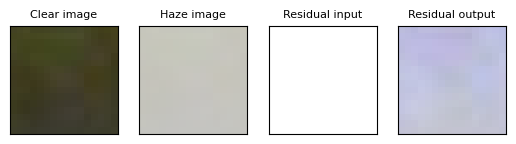

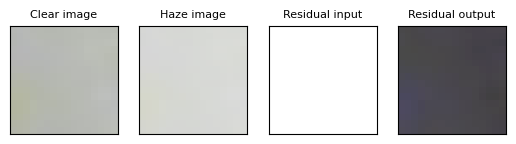

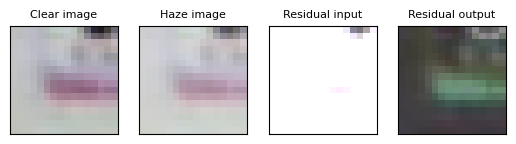

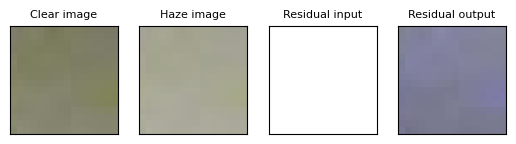

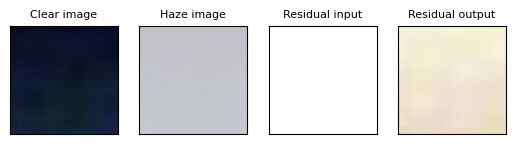

In [4]:
for i in range(5):
    fig, axes = plt.subplots(1, 4)
    axes[0].imshow(clear_images[i])
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title('Clear image', size = 8)
    axes[1].imshow(haze_images[i])
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title('Haze image', size = 8)
    axes[2].imshow(residual_input[i])
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    axes[2].set_title('Residual input', size = 8)
    axes[3].imshow(residual_output[i])
    axes[3].set_xticks([])
    axes[3].set_yticks([])
    axes[3].set_title('Residual output', size = 8)

In [5]:
model = ResidualModel()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer = optimizer, step_size = 10, gamma = 0.1)
num_epochs = 100

In [6]:
def set_seed(seed):
    """
    Function for seed setting
    """

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train_res_model(num_epochs, model, loss_fn, optimizer, residual_input, residual_output, device = 'cuda', seed = 42, lr_scheduler = None):
    """
    Function for training residual model
    """

    set_seed(seed)

    model.to(device)

    residual_input_tensor = torch.tensor(residual_input.transpose(0, 3, 1, 2)).float().to(device)
    residual_output_tensor = torch.tensor(residual_output.transpose(0, 3, 1, 2)).float().to(device)

    dataset = TensorDataset(residual_input_tensor, residual_output_tensor)
    batches = DataLoader(dataset = dataset, batch_size = 16, shuffle = True)

    for epoch in range(num_epochs):
        model.train()

        loss_epoch = 0.0

        for batch_idx, batch in enumerate(batches):
            residual_input_batch, residual_output_batch = batch

            loss_train = 0.0

            optimizer.zero_grad()

            predict = model(residual_input_batch)

            loss = loss_fn(residual_output_batch, predict)

            loss.backward()

            optimizer.step()

            loss_epoch += loss.item()
        
        print(f'Epoch: {epoch + 1} Loss epoch: {loss_epoch / len(batches)}')

        if lr_scheduler:
            lr_scheduler.step()


In [7]:
train_res_model(num_epochs = num_epochs, model = model, loss_fn = loss_fn, optimizer = optimizer, residual_input = residual_input, residual_output = residual_output)

Epoch: 1 Loss epoch: 0.25829242582321166
Epoch: 2 Loss epoch: 0.17667858499288558
Epoch: 3 Loss epoch: 0.12295094968080521
Epoch: 4 Loss epoch: 0.07881272718906403
Epoch: 5 Loss epoch: 0.07416226018667221
Epoch: 6 Loss epoch: 0.06997397634387016
Epoch: 7 Loss epoch: 0.06800667839348316
Epoch: 8 Loss epoch: 0.06648299179971218
Epoch: 9 Loss epoch: 0.0658873637586832
Epoch: 10 Loss epoch: 0.0653609695672989
Epoch: 11 Loss epoch: 0.06498146383464336
Epoch: 12 Loss epoch: 0.0646935511469841
Epoch: 13 Loss epoch: 0.06431876424252987
Epoch: 14 Loss epoch: 0.06423334784209728
Epoch: 15 Loss epoch: 0.06391648981273174
Epoch: 16 Loss epoch: 0.06342200637757778
Epoch: 17 Loss epoch: 0.06328077537417412
Epoch: 18 Loss epoch: 0.06319765092134476
Epoch: 19 Loss epoch: 0.06299336150288581
Epoch: 20 Loss epoch: 0.06284843160510063
Epoch: 21 Loss epoch: 0.06265892372429371
Epoch: 22 Loss epoch: 0.06262605203688144
Epoch: 23 Loss epoch: 0.062380665645003316
Epoch: 24 Loss epoch: 0.06230213037133217
Epo

In [31]:
residual_input[:10].shape

(10, 16, 16, 3)

In [41]:
out = model(torch.tensor(residual_input[:10].transpose(0, 3, 1, 2)).float().to('cuda'))
out = out.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
out = residual_input[:10] - out

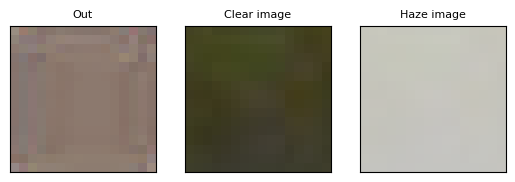

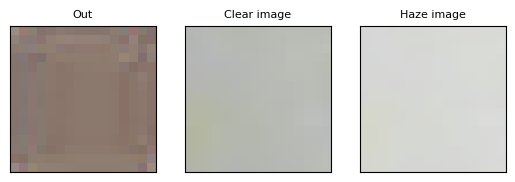

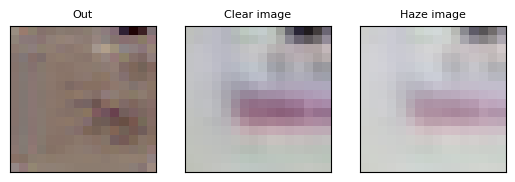

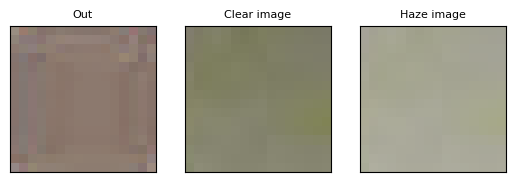

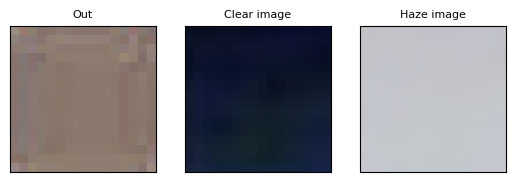

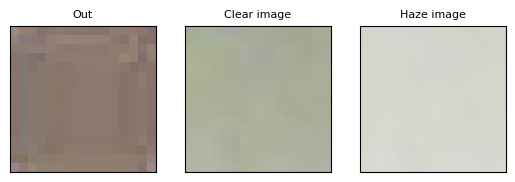

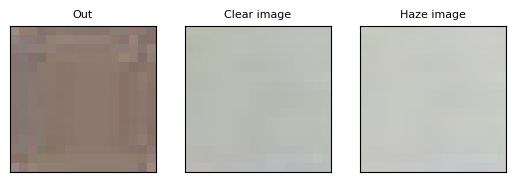

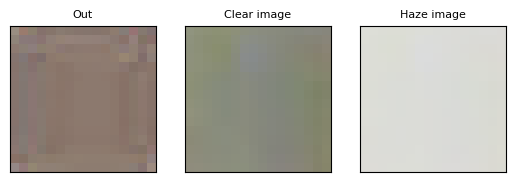

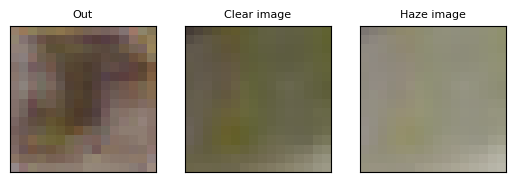

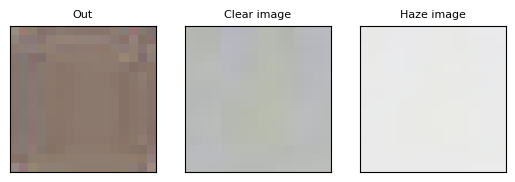

In [42]:
for i in range(10):
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(out[i])
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title('Out', size = 8)
    axes[1].imshow(clear_images[i])
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title('Clear image', size = 8)
    axes[2].imshow(haze_images[i])
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    axes[2].set_title('Haze image', size = 8)

In [43]:
torch.save(model.state_dict(), 'res_model_weights.pt')